<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---




<p align="center"><h1 align="center">Flower Image Classification with PyTorch</h1> <h3 align="center">(Prepare to deploy model and preprocessor to REST API/Web Dashboard in four easy steps...)</h3></p>
<p align="center"><img width="80%" src="https://aimodelsharecontent.s3.amazonaws.com/ModelandPreprocessorObjectPreparation.jpeg" /></p>


---



## **(1) Preprocessor Function & Setup**

In [1]:
# Importing images from tensorflow compressed .tgz file...
FLOWERS_DIR = 'flower_photos' # Downloading to this directory drom the download URL.
def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)

import os
from six.moves import urllib

# Download the images to flower_photos folder...
download_images()

Flower photos are located in flower_photos


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import random

random.seed(42)

In [3]:
data_path = 'flower_photos'

In [4]:
from pathlib import Path

image_paths = []
for path in Path(data_path).rglob('*.jpg'):
    image_paths.append(str(path))

### **Write a Preprocessor Function**

In [5]:
def preprocessor(data_path, shape):
        """
        This function preprocesses/reads in images, resizes them to a fixed shape and
        min-max transforms them before converting feature values to float32 numeric values
        required by ONNX. (NB Use GPU for your models.)
        
        params:
            data_path
                list of unprocessed images
            shape
                dsize of images to be moulded into
                      
        returns:
            preprocessed_img
                preprocessed image data
                  
        """
           
        import cv2

        img = cv2.imread(data_path) # Read in the image.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=shape)
        img = img / 255.0 # Normalization.
        preprocessed_img = img.astype('float32') # float32 for ONNX.
        return preprocessed_img

In [6]:
X = [preprocessor(x, shape=(128, 128)) for x in image_paths] # X becomes list of ndarray's with shape (128, 128, 3).

In [7]:
classes = ('tulips', 'daisy', 'dandelion', 'sunflowers', 'roses')

In [8]:
import os
import matplotlib.pyplot as plt

dir = data_path
classes = [clas.name for clas in os.scandir(dir) if clas.is_dir()]

arr, y = [], []
for clas in classes:
    path=os.path.join(dir,clas)
    for img in os.listdir(path):
        arr.append(plt.imread(os.path.join(path,img)))
        y.append(str(clas))

In [ ]:
# image_paths (X) vs. y.

In [12]:
import pandas as pd
y_ = pd.DataFrame(y)
y_ = y_[0].map({'daisy': 0, 'dandelion': 1, 'roses': 2, # Make sure it matches the `image_paths` order.
                'sunflowers': 3, 'tulips': 4}) # 'daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'.
y_ = list(y_)
y_ = sorted(y_)

In [13]:
target_arr = np.array(y_)

In [14]:
target_arr.shape # Check shape.

(3670,)

In [15]:
target_arr.shape[0]

3670

`torch` tensors assume color channel is the **first** dimension, whereas `matplotlib` assumes it's the **third** dimension. Therefore always convert images (H x W x **C**) to a `torch.Tensor` of shape (**C** x H x W), and vice-versa for plotting.

In [16]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tX = torch.Tensor(X) # Tensor with shape torch.Size([3670, 128, 128, 3]).
tensor_X = np.transpose(tX, (0, 3, 1, 2)) # Tensor with shape torch.Size([3670, 3, 128, 128]).
tensor_y = torch.from_numpy(target_arr) # Tensor with shape torch.Size([3670]).

my_dataset = TensorDataset(tensor_X, tensor_y) # My datset.

In [17]:
def custom_loader(dataset, batch_size, training, num_workers, **kwargs):

    test_split = .2 # 20% in the test set.
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(test_split * dataset_size))
    training_indices, test_indices = indices[split:], indices[:split]
    sampler = {
        'training_sampler': SubsetRandomSampler(training_indices),
        'test_sampler': SubsetRandomSampler(test_indices)
        }
    my_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size,
                                            sampler=sampler['training_sampler' if training else 'test_sampler'],
                                            **kwargs)
    return my_loader

In [18]:
trainloader = custom_loader(dataset=my_dataset, batch_size=1, training=True, num_workers=4)

In [19]:
testloader = custom_loader(dataset=my_dataset, batch_size=1, training=False, num_workers=4)

In [20]:
print(f'Number of training items: {len(trainloader)}')
print(f'Number of test items: {len(testloader)}')

Number of training items: 2936
Number of test items: 734


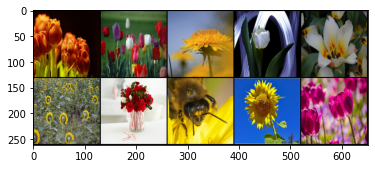

tulips tulips dandelion tulips tulips sunflowers tulips dandelion sunflowers tulips


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Display some images...
def imshow(img):
  # img = img / 2 + 0.5 # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # PyTorch tensors assume color channel is 1st dim,
                                               # but matplotlib assumes it's the 3rd dim.
    plt.show()

# Get some random training images...
dataiter = iter(trainloader)
it1 = dataiter.next(); it2 = dataiter.next(); it3 = dataiter.next(); it4 = dataiter.next(); it5 = dataiter.next();
it6 = dataiter.next(); it7 = dataiter.next(); it8 = dataiter.next(); it9 = dataiter.next(); it10 = dataiter.next()
its = it1 + it2 + it3 + it4 + it5 + it6 + it7 + it8 + it9 + it10 # Iterations.

def everyOther(list_of_tensors):
    return list_of_tensors[::2]

def theRest(list_of_tensors):
    return list_of_tensors[1::2]

images_list = everyOther(its); labels_list = theRest(its)
images = torch.cat(images_list, 0); labels = torch.cat(labels_list, 0);

# Show images...
imshow(torchvision.utils.make_grid(images, nrow=5))

# And print labels...
labels_ = pd.DataFrame(labels)
labels_ = labels_[0].map({0: 'daisy', 1: 'dandelion', 2: 'roses',
                          3: 'sunflowers', 4: 'tulips'})
print(' '.join('%5s' % labels_[j] for j in range(10)))

In [22]:
use_cuda = torch.cuda.is_available()

In [23]:
# Ensures `cuda` is used for both input data and model, so that they match:
torch.set_default_dtype(torch.float32)
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

## **(2) Train Model Using `torch`**

In [24]:
def step(model, loader, train=False, optimizer=None, use_cuda=False):
    """
    This function completes one epoch over the dataset (wrapped by the loader) computing
    the losses and accuracies over the datasets. It also trains the model parameters if
    in train mode.
    
    params:
        model
            pytorch.nn.Module object which implements a forward method to propogate over
            the network
            
        loader
            pytorch.utils.data.DataLoader which iterates over the dataset generating
            batches of samples
            
        train [default=False]
            the model is trained if this is true
            
        optimizer [default=None]
            pytorch optimizer to use if in training mode
        
        use_cuda [default=False]
            use gpu device if true
        
    returns:
        loss
            total loss over the dataset
        
        acc
            accuracy of predictions over the dataset. This is not completely accurate as
            we compute the accuracy while training on mini-batches
    """
    
    if train:
        
        assert optimizer is not None, "Need to pass an optimizer if in train mode."

        model.train() # Set model in training mode.

    else:
        
        model.eval() # Set model in evaluation mode.

    loss = 0
    correct = 0
    num_samples = 0

    # Loop over mini-batches of the dataset:
    for i, (batch_images, batch_labels) in enumerate(loader):
        if use_cuda:
            # Change device to cuda for the data.
            batch_images = batch_images.cuda()
            batch_labels = batch_labels.cuda()

        # Compute outputs from the model and corresponding loss:
        outputs = model(batch_images)
        batch_loss = model.loss_fn(outputs, batch_labels)

        loss += batch_loss.item() # Add to total loss.

        if train:
            # Step the optimizer to backprop over the model and train the parameters.
            # This is simply one step of gradient descent however using the given optim.
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Compute predicted labels and corresponding accuracy:
        _, predicted = torch.max(outputs.data, axis=1)
        correct += (predicted == batch_labels).sum().item()

        num_samples += len(batch_labels)

    loss = loss / len(loader) # loss should be averaged over batches (approx.).
    
    acc = correct / num_samples # acc should be computed as: "correctly predicted samples" / "samples" (approx.).

    return loss, acc

In [25]:
def train(model, optimizer, train_loader, val_loader, num_epochs=30, use_cuda=False):
    """
    This function trains the model for the given number of epochs while reporting the
    results using tqdm.
    
    params:
        model
            pytorch.nn.Module object which implements a forward method to propogate over
            the network
            
        optimizer
            pytorch optimizer to use for training
            
        train_loader
            pytorch.utils.data.DataLoader which specifies the training dataset
            
        val_loader
            pytorch.utils.data.DataLoader which specifies the validation dataset
            
        num_epochs [default=30]
            number of epochs to run training for
        
        use_cuda [default=False]
            use gpu device if true
            
    returns:
        train_losses
            list of losses for training dataset
            
        val_losses
            list of losses for validation dataset
            
        train_accs
            list of accuracies for training dataset
            
        val_accs
            list of accuracies for validation dataset
    """
    
    val_losses = list()
    train_losses = list()

    val_accs = list()
    train_accs = list()

    from tqdm import tqdm

    with tqdm(range(num_epochs)) as bar:
        bar.set_postfix(
            {
                "tr_loss": float("inf"),
                "tr_acc": 0.0,
                "val_loss": float("inf"),
                "val_acc": 0.0,
            }
        )

        # Stores weights for best model and best validation accuracy:

        import copy
        from copy import deepcopy

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in bar:
            loss = 0
            correct = 0

            tr_loss, tr_acc = step(model, train_loader,
                                   train=True, optimizer=optimizer, use_cuda=use_cuda)
            val_loss, val_acc = step(model, val_loader, train=False, use_cuda=use_cuda)

            train_losses.append(tr_loss)
            val_losses.append(val_loss)

            train_accs.append(tr_acc)
            val_accs.append(val_acc)

            if val_acc > best_acc:
                # Update best model weights if val_acc better than best_acc:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = val_acc

            bar.set_postfix(
                {
                    "tr_loss": tr_loss,
                    "tr_acc": tr_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                }
            )
        
        model.load_state_dict(best_model_wts) # Restore best model weights encountered over all epochs.

    return train_losses, val_losses, train_accs, val_accs

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Implements the CNN module for classification. The layers for this model are:
    
        1. Input [3 x 128 x 128]
        2. 2D Convolution [3 x 16, kernel=5, padding=2] -> ReLU
        3. 2D Max Pooling
        4. 2D Convolution [16 x 32, kernel=5, padding=2] -> ReLU
        5. Linear [1024] -> ReLU
        6. Linear [256] -> ReLU
        7. Linear [5] -> Softmax
    """

    def __init__(self, loss_fn, n_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)

        self.fc1 = nn.Linear(in_features=512, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=n_classes)

        self.loss_fn = loss_fn

    def forward(self, x):
        """
        This function defines the forward propogation logic for the model class.
        """

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [27]:
loss_fn = nn.CrossEntropyLoss()
model = CNN(loss_fn, len(classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [28]:
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [29]:
train_losses, val_losses, train_accs, val_accs = train(
    model, optimizer, trainloader, testloader, use_cuda=use_cuda)

100%|██████████| 30/30 [05:38<00:00, 11.29s/it, tr_loss=0.0701, tr_acc=0.98, val_loss=139, val_acc=0.112]


## **(3) Save Preprocessor**

In [ ]:
# ! pip3 install aimodelshare

In [30]:
def export_preprocessor(preprocessor_function, filepath):
    import dill
    with open(filepath, "wb") as f:
        dill.dump(preprocessor_function, f)

# import aimodelshare as ai # Once we can deploy this, we use it in lieu of the below.
# ai.export_preprocessor(preprocessor, "preprocessor.pkl")

export_preprocessor(preprocessor, "preprocessor.pkl")

## **(4) Save to ONNX**

In [31]:
dummy_input = next(iter(trainloader))[0]

torch.onnx.export(
    model.cpu(),
    dummy_input,
    "my_model.onnx",
    export_params=True,
    do_constant_folding=True,
)